### Libraries

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from lib import analysis, enrich, data_generation
from scipy import stats
from scipy import io
from tqdm import tqdm
import os

### Import data

In [2]:
user_col = 'user'
item_col = 'item'
predict_col = 'rating'
location = 'data/'

Real data.

In [3]:
fairbook_ratings = pd.read_csv(
    location + 'fairbook/fairbook_events.csv', header=0,
)

In [4]:
mat = io.loadmat(location+"epinion/epinion_events.mat")
mat_df = pd.DataFrame(mat['rating_with_timestamp'])
mat_df.columns = [user_col, item_col, '.', predict_col, '..', '...']
epinion_ratings = mat_df[[user_col,item_col,predict_col]].drop_duplicates(subset = [user_col,item_col], keep='last')

In [5]:
ml1m_ratings = pd.read_csv(
    location+'movielens_1m/ml1m_events.dat', header=None, sep="::", engine="python"
).drop(3, axis=1)
ml1m_ratings.columns = [user_col, item_col, predict_col]

Synthetic data.

In [6]:
data_strategies = [
    "uniformly_random",
    "popularity_good",
    "popularity_bad",
    "popularity_good_for_bp_ur",
    "popularity_bad_for_bp_ur",
]

In [7]:
synthetic_data = []
for i in tqdm(range(len(data_strategies))):
    ds = data_strategies[i]
    ratings = pd.read_csv('data/'+ds+'/'+ds+'.csv')
    synthetic_data.append(ratings)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 57.99it/s]


### Analyze data

In [26]:
def do_analysis(ratings, data_strategy, perc_top=0.2):
    # Assuming analysis and enrich are defined elsewhere
    # analysis.users_and_items(ratings, user_col, item_col)
    user_dist, num_users = analysis.user_distribution(ratings, user_col, item_col, verbose=False)
    item_dist, num_items = analysis.item_distribution(ratings, user_col, item_col, verbose=False)
    item_rating_dist = analysis.item_rating(ratings, item_col, predict_col, verbose=False)
    
    df_item_dist = pd.DataFrame(item_dist)
    df_item_dist.columns = ['count']
    full_item_dist = pd.merge(df_item_dist, item_rating_dist, left_index=True, right_index=True)

    font = {'size': 15}
    matplotlib.rc('font', **font)
    
    # First plot: item rating vs popularity
    x1 = full_item_dist['count'].values
    y1 = full_item_dist.rating.values
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1, y1)
    line1 = slope1 * np.array(x1) + intercept1

    uc, ic = enrich.calculate_userKNN_characteristics(ratings, user_dist, item_dist, user_col, item_col, predict_col, df_item_dist, divide_by='pop_item_fraq')

    num_top = int(perc_top * num_users) + 1
    bp_users = uc.sort_values(by='count', ascending=False).iloc[:num_top]
    item_bp_rat_bp = analysis.item_rating(ratings[ratings.user.isin(bp_users.index)], item_col, predict_col)
    item_bp_pop_rat = pd.merge(df_item_dist, item_bp_rat_bp, left_index=True, right_index=True)
    full_item_dist_but_only_bp_items = pd.merge(full_item_dist, item_bp_rat_bp, left_index=True, right_index=True)
    
    # Second plot: item rating vs popularity for bp users
    x2 = item_bp_pop_rat['count'].values
    y2 = item_bp_pop_rat.rating.values
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2, y2)
    line2 = slope2 * np.array(x2) + intercept2

    # Combined plot
    fig, ax = plt.subplots(1, 1)
    
    # Plot first scatter and line
    ax.scatter(x1, y1, s=10, label='Among all users', color='#ef8a62', alpha=0.6)
    ax.plot(x1, line1, color='#ef8a62', linestyle='dashed')

    # Plot second scatter and line
    ax.scatter(x2, y2, s=10, label='Among users with big profiles', color='#67a9cf', alpha=0.2)
    ax.plot(x2, line2, color='#67a9cf', linestyle='dashed')

    ax.set_xlabel("Item popularity", fontsize=20)
    ax.set_ylabel("Item average rating", fontsize=20)
    # ax.set_title(data_strategy, fontsize=20)

    # Add legends for clarity
    ax.legend()

    # Save and show the plot
    
    plt.savefig('plots/data_analysis_'+data_strategy+'.png', transparent=True, bbox_inches='tight')
    plt.show()

Start.

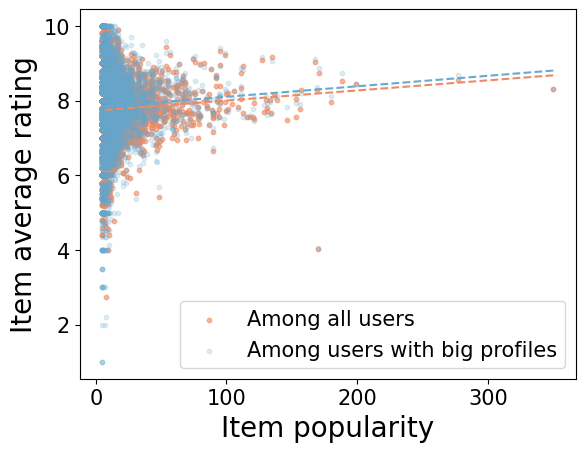

In [27]:
do_analysis(fairbook_ratings, 'Book-Crossing', perc_top = 0.2)

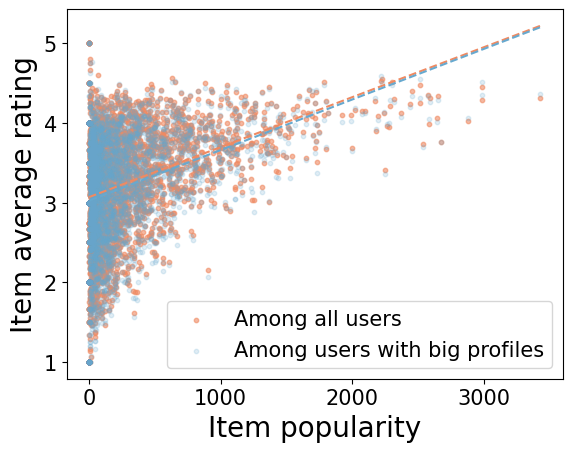

In [28]:
do_analysis(ml1m_ratings, 'MovieLens1M', perc_top = 0.2)

/tmp/ipykernel_1002897/1374726011.py:55: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('plots/data_analysis_'+data_strategy+'.png', transparent=True, bbox_inches='tight')


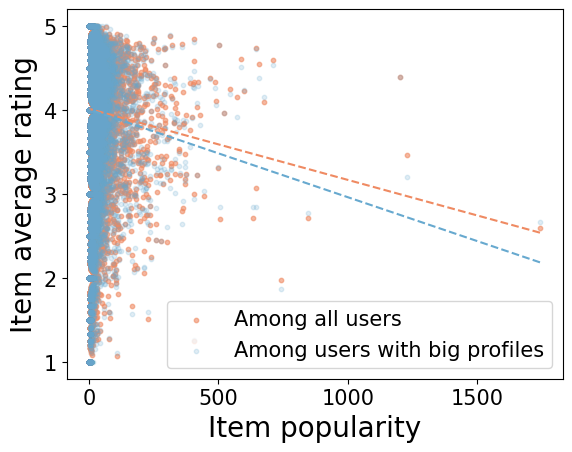

In [29]:
do_analysis(epinion_ratings, 'Epinion', perc_top = 0.2)

  0%|                                                                                                                                                                                                                                                                | 0/5 [00:00<?, ?it/s]

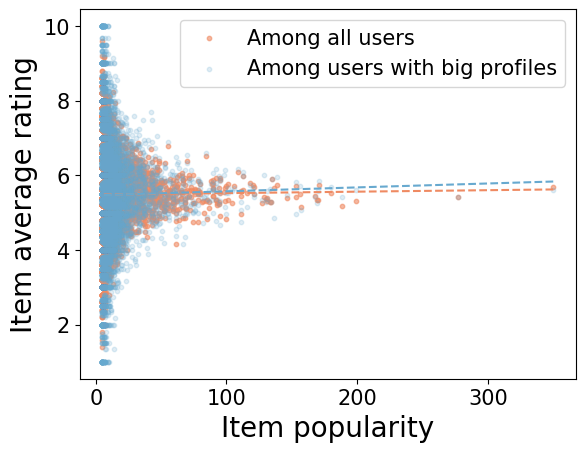

 20%|█████████████████████████████████████████████████▌                                                                                                                                                                                                      | 1/5 [00:05<00:22,  5.63s/it]

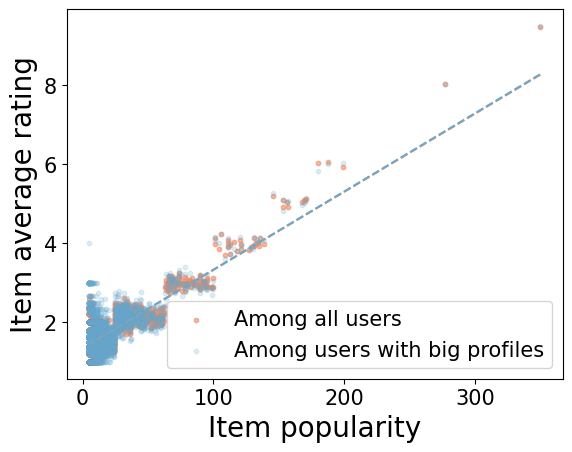

 40%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 2/5 [00:11<00:17,  5.74s/it]

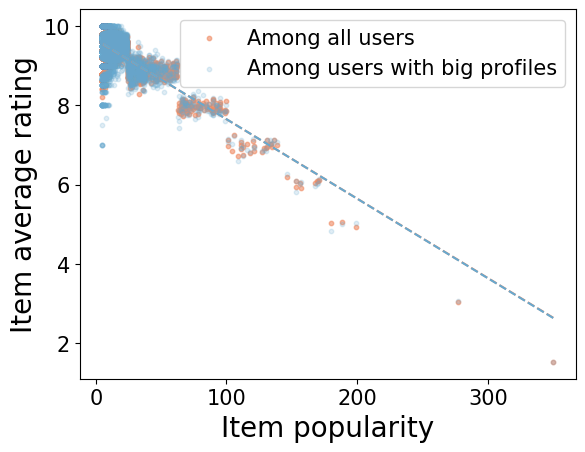

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 3/5 [00:17<00:11,  5.68s/it]

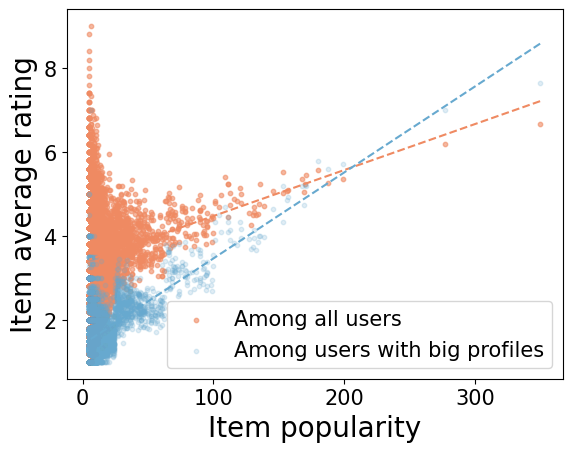

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 4/5 [00:23<00:05,  5.81s/it]

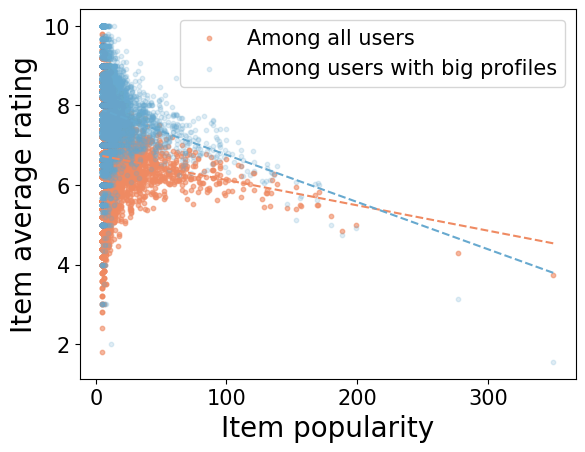

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.74s/it]


In [30]:
for i in tqdm(range(len(data_strategies))):
    ratings =synthetic_data[i]
    do_analysis(ratings, 'Scenario '+str(i+1),perc_top = 0.2)